In [ ]:
!pip install GPUtil

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=1ee05c2e03136ef494be60ab9894786fc31c9d9667f592c513a0dcf2da6c616e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
from src.mlmodel import *
import src.utils as utils
from argparse import ArgumentParser
from ZSTL_GPU import ZSTL
import timeit
#import GPUtil
import sys

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
net = FuncRecursiveNet([
        FLinearLayer(200, True),
        FActivation(F.relu),
        #  FLinearLayer(100, True),
        # FActivation(F.relu),
        FLinearLayer(1, True)
    ])


shape_record = {0: [(1, 2049)]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#GPUtil.showUtilization()

cuda:0
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
# !ls ./drive/'My Drive'/'thesis_data'/'hetrec'/
# !cp ./drive/'My Drive'/'thesis_data'/'hetrec'/'detailed_data_0826.pickle' ./
# !cp ./drive/'My Drive'/'thesis_data'/'hetrec'/'sampled_task_0826.pickle' ./

detailed_data_0826.pickle	    LastFM_te.mat
detailed_data_colNormalizeA.pickle  LastFM_Xtr.mat
LastFM.mat			    sampled_task_0826.pickle
LastFM_R_te.mat			    sampled_task_colNormalizeA.pickle
LastFM_Str.mat


In [ ]:
path_data = './ZSTL_Data/hetrec2011-lastfm-2k/extracted_feature/'
compressed_data = 'sampled_task_0826.pickle'
detailed_data = 'detailed_data_0826.pickle'

with open(path_data+compressed_data, 'rb') as f:
    compressed_dataset = pickle.load(f)

with open(path_data+detailed_data, 'rb') as f:
    detailed_dataset = pickle.load(f)

In [ ]:
train_batch_size = 100
task_id = list(compressed_dataset.keys())
tot_len = len(task_id)
train_size = int(0.8*tot_len)
test_size = tot_len  - train_size
print('train_size ', train_size, 'test_size ', test_size)

support_size = 50
np.random.seed(0)
train_indx_full = list(np.random.choice(task_id, size=train_size, replace=False))
print(train_indx_full)
support_indx = list(np.random.choice(train_indx_full, size=support_size, replace=False))
print(support_indx)


print(len(train_indx_full))
test_indx = [x for x in task_id if x not in train_indx_full]
print(len(test_indx))
print(test_indx)

train_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in train_indx_full], detailed_dataset, train_task=False, learner='NN')
preset_x =  train_data.x
print('preset x ',preset_x.shape)
del train_data


train_indx = [x for x in train_indx_full if x not in support_indx]
print(len(support_indx), len(train_indx), sys.getsizeof(preset_x))

support_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in support_indx], \
                              detailed_dataset, preset_x =preset_x, train_task=True, learner='NN', device=device)


shape_record = support_data.shape_record

train_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in train_indx], detailed_dataset,preset_x =preset_x, train_task=False, \
                            learner='NN', device=device)
test_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in test_indx], detailed_dataset, preset_x = preset_x, learner='NN', \
                           train_task=False, device=device)

support_loader = DataLoader(support_data, batch_size=support_size, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=train_batch_size, shuffle=True)

support_a, support_w, support_x, support_y = next(iter(support_loader))
print(support_a.shape, support_w.shape, support_x.shape, support_y.shape)
#del support_loader, support_data, support_x, support_y

train_a, train_w, train_x, train_y = next(iter(train_loader))
train_a, train_w, train_x, train_y = train_a.float(), train_w.float(), train_x.float(), train_y.float()
print(train_a.shape, train_w.shape, train_x.shape, train_y.shape)
del train_a, train_w, train_x, train_y, train_data
#print(train_a)

train_size  1513 test_size  379
[310, 348, 1661, 1543, 1323, 1060, 806, 948, 471, 2018, 81, 456, 1271, 1393, 30, 1894, 625, 154, 123, 141, 1599, 961, 1999, 387, 1420, 642, 2007, 484, 1826, 1944, 212, 1798, 21, 537, 1782, 1318, 129, 89, 1156, 2080, 1355, 1150, 1838, 696, 80, 56, 244, 185, 1552, 1687, 633, 1377, 778, 577, 1044, 1354, 1722, 8, 458, 1481, 20, 1451, 344, 1484, 1640, 574, 1904, 612, 112, 84, 856, 1566, 376, 1368, 1881, 1039, 1840, 607, 686, 606, 50, 567, 622, 1470, 1611, 33, 940, 1231, 1506, 862, 1493, 598, 726, 663, 491, 1736, 2013, 296, 420, 1949, 1327, 281, 1292, 912, 237, 1140, 229, 1413, 1959, 2020, 234, 1925, 1180, 1718, 1695, 1545, 828, 1924, 1113, 171, 1691, 763, 913, 1865, 1623, 2051, 163, 623, 271, 508, 802, 1617, 1247, 2097, 1345, 1994, 2042, 627, 526, 1134, 787, 250, 489, 1390, 1819, 584, 548, 2024, 2091, 689, 832, 1477, 1522, 1149, 1794, 477, 1930, 37, 298, 1356, 769, 1622, 823, 198, 1233, 1505, 728, 2079, 887, 1310, 192, 2095, 1151, 875, 657, 355, 16, 1388, 110

100%|██████████| 50/50 [00:32<00:00,  1.54it/s]


shape record  {0: [(200, 9749)], 1: [(200,)], 2: [(1, 200)], 3: [(1,)]}
gen w done
learner  NN
not gen w
learner  NN
not gen w
torch.Size([50, 1, 1892]) torch.Size([50, 1, 1950201]) torch.Size([50, 100, 9749]) torch.Size([50, 100, 1])
torch.Size([100, 1, 1892]) torch.Size([100, 1, 1]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])


In [ ]:
support_a = support_a.float().squeeze().t()
support_w = support_w.float().squeeze().t()
dm = support_a.size()[0]
print(dm)
d  = support_w.size()[0]
print(d)
print(support_a.shape, support_w.shape)

print('shape record ', shape_record)
param_dict = {}
param_dict['rho'] = 1e-5
param_dict['mu'] = 0.0001
param_dict['loss'] = 'mAP'
param_dict['outer lr'] = 5e-4
param_dict['align lr'] = 5e-4
param_dict['dm'] = dm
param_dict['d'] = d
param_dict['model_shape'] = shape_record
param_dict['atten_activation'] = 'Sparsemax'
print(param_dict)

1892
1950201
torch.Size([1892, 50]) torch.Size([1950201, 50])
shape record  {0: [(200, 9749)], 1: [(200,)], 2: [(1, 200)], 3: [(1,)]}
{'rho': 1e-05, 'mu': 0.0001, 'loss': 'mAP', 'outer lr': 0.0005, 'align lr': 0.0005, 'dm': 1892, 'd': 1950201, 'model_shape': {0: [(200, 9749)], 1: [(200,)], 2: [(1, 200)], 3: [(1,)]}, 'atten_activation': 'Sparsemax'}


test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7048999999999999; align loss 0.0764148160815239
1/800 o_loss 1.1677653905749321; m train metric 0.7531000000000004; m test metric 0.7328999999999998; align loss  9.12696123123169e-05
200/800 o_loss 0.38869492016732693; m train metric 0.8521000000000001; m test metric 0.8008; align loss  7.098913192749023e-05
400/800 o_loss 0.3274463976174593; m train metric 0.8821000000000002; m test metric 0.7995000000000002; align loss  5.856156349182129e-05
600/800 o_loss 0.3102322005107999; m train metric 0.8936999999999999; m test metric 0.7945; align loss  4.855543375015259e-05
800/800 o_loss 0.30740602850914; m train metric 0.9022999999999994; m test metric 0.7919000000000002; align loss  4.014931619167328e-05
lr  0.0005


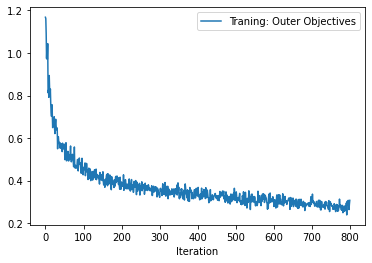

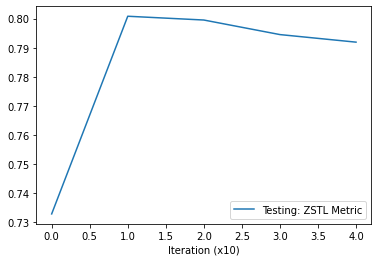

Time: 1215.245990337
| ID | GPU | MEM |
------------------
|  0 | 12% | 44% |


In [ ]:

start = timeit.default_timer()
ZSTL_model = ZSTL(support_w, support_a, net, param_dict, device)
ZSTL_model.train(train_loader, test_loader, max_iter=800)
stop = timeit.default_timer()
print('Time:', stop - start)
GPUtil.showUtilization()



In [ ]:
test_data_full = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in test_indx], detailed_dataset, preset_x =preset_x, phase='mAP', train_task=False)
test_data_full_loader = DataLoader(test_data_full, batch_size=test_size, shuffle=True)

test_batch = next(iter(test_data_full_loader))
test_a, test_w, test_y = test_batch[0].float(), test_batch[1].float(), \
    test_batch[2].float()

test_x = utils.toTensor(preset_x)
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()
print(test_a.shape, test_w.shape, test_y.shape, test_x.shape)

learner  LR
not gen w
torch.Size([1892, 379]) torch.Size([379]) torch.Size([379, 17632, 1]) torch.Size([17632, 9749])


In [ ]:

pred_precision = utils.ZSTL_AvgPrecision(test_a, test_x, test_y, ZSTL_model)
# del ZSTL_model
# torch.cuda.empty_cache()
GPUtil.showUtilization()

mAP at 100  tensor(0.3024, dtype=torch.float64) num task  tensor(379., dtype=torch.float64) precision at k 0.13218997361477572 recall at k 0.2669066974308371
| ID | GPU | MEM |
------------------
|  0 |  4% | 66% |


292
1171
learner  NN
not gen w
learner  NN
not gen w
learner  NN
not gen w
100
torch.Size([1892, 292])
num of hp  25
rho for w_kb 0.1; mu for a_kb 0.1;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7178999999999998; align loss 0.7640149593353271
1/600 o_loss 2.938869040608406; m train metric 0.7491000000000001; m test metric 0.7379999999999999; align loss  0.0007788538932800293
200/600 o_loss 0.4926276229321957; m train metric 0.8466999999999998; m test metric 0.7930000000000001; align loss  0.0006635785102844238
400/600 o_loss 0.38893448136746883; m train metric 0.8612999999999998; m test metric 0.7932000000000002; align loss  0.0005626082420349121
600/600 o_loss 0.3656435681879521; m train metric 0.8694000000000005; m test metric 0.7889000000000002; align loss  0.00047329068183898926
lr  0.0005


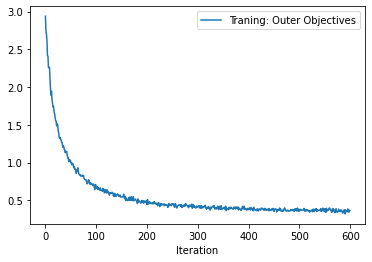

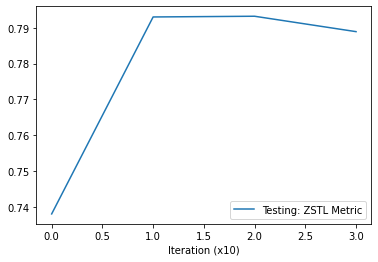

mAP at 100  tensor(0.3200, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13551369863013701
mean metric 0.3199885163117386
New best acc 0.3199885163117386
rho for w_kb 0.1; mu for a_kb 0.01;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7008000000000003; align loss 0.7640147805213928
1/600 o_loss 2.8287549597024917; m train metric 0.7615; m test metric 0.7237; align loss  0.0007789134979248047
200/600 o_loss 0.49160902693867686; m train metric 0.8489999999999998; m test metric 0.7918999999999999; align loss  0.0006635189056396484
400/600 o_loss 0.37551675766706466; m train metric 0.8687999999999999; m test metric 0.7875999999999999; align loss  0.0005626678466796875
600/600 o_loss 0.3500748527795076; m train metric 0.8826000000000002; m test metric 0.7877999999999998; align loss  0.00047329068183898926
lr  0.0005


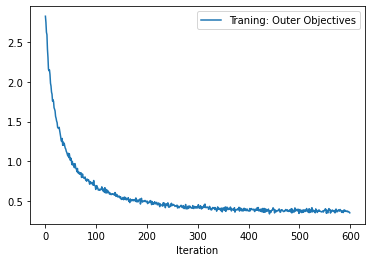

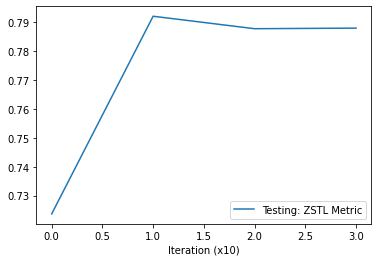

mAP at 100  tensor(0.3096, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13421232876712325
mean metric 0.3095820359392763
rho for w_kb 0.1; mu for a_kb 0.001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7267000000000001; align loss 0.7640148401260376
1/600 o_loss 2.948877023756504; m train metric 0.7626999999999999; m test metric 0.7528999999999995; align loss  0.0007790327072143555
200/600 o_loss 0.48108187280595305; m train metric 0.8583000000000003; m test metric 0.8047000000000001; align loss  0.0006635189056396484
400/600 o_loss 0.3624901454895735; m train metric 0.8761000000000001; m test metric 0.8009; align loss  0.0005626678466796875
600/600 o_loss 0.3567290481179953; m train metric 0.8771; m test metric 0.8021999999999998; align loss  0.00047335028648376465
lr  0.0005


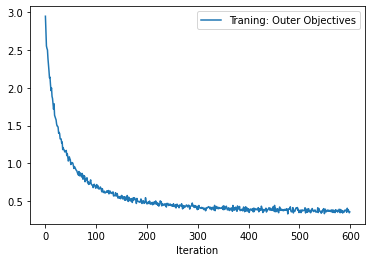

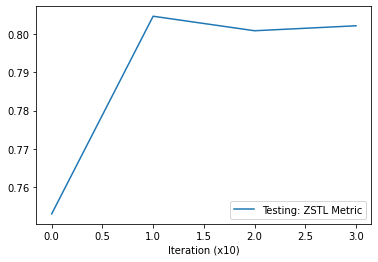

mAP at 100  tensor(0.3134, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13147260273972597
mean metric 0.3134024826079829
rho for w_kb 0.1; mu for a_kb 0.0001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7189999999999996; align loss 0.7640147805213928
1/600 o_loss 2.903248644769192; m train metric 0.7496; m test metric 0.7440000000000002; align loss  0.0007789731025695801
200/600 o_loss 0.4604865423589945; m train metric 0.8576; m test metric 0.8064999999999999; align loss  0.0006636977195739746
400/600 o_loss 0.4031604231148958; m train metric 0.8729000000000003; m test metric 0.8021000000000003; align loss  0.0005626082420349121
600/600 o_loss 0.37366683840751647; m train metric 0.8809999999999999; m test metric 0.7998999999999999; align loss  0.00047332048416137695
lr  0.0005


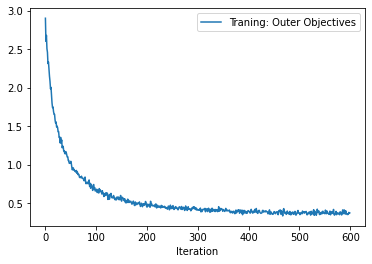

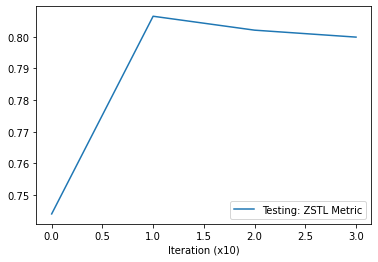

mAP at 100  tensor(0.3154, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1350342465753425
mean metric 0.31537695826665785
rho for w_kb 0.1; mu for a_kb 1e-05;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7181999999999996; align loss 0.7640148997306824
1/600 o_loss 2.879577735364437; m train metric 0.7553; m test metric 0.7355999999999999; align loss  0.0007787942886352539
200/600 o_loss 0.47581603392958643; m train metric 0.8525999999999999; m test metric 0.7986999999999997; align loss  0.0006635785102844238
400/600 o_loss 0.37381329625844956; m train metric 0.8737; m test metric 0.7907; align loss  0.0005626082420349121
600/600 o_loss 0.3695711383968592; m train metric 0.8642999999999996; m test metric 0.7943000000000001; align loss  0.00047335028648376465
lr  0.0005


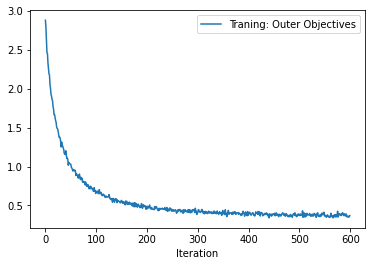

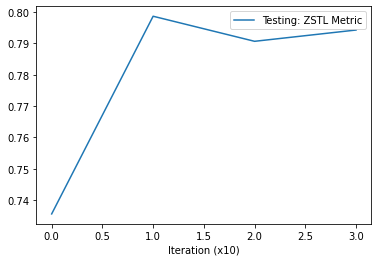

mAP at 100  tensor(0.3117, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1316438356164384
mean metric 0.31169910471795936
rho for w_kb 0.01; mu for a_kb 0.1;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7273999999999999; align loss 0.7640148401260376
1/600 o_loss 2.843809696286917; m train metric 0.765; m test metric 0.7422; align loss  0.0007786750793457031
200/600 o_loss 0.46269027426838877; m train metric 0.8535000000000003; m test metric 0.8109000000000002; align loss  0.0006635189056396484
400/600 o_loss 0.37911292739212515; m train metric 0.8654; m test metric 0.8095; align loss  0.0005626082420349121
600/600 o_loss 0.3915046899020672; m train metric 0.8642000000000002; m test metric 0.8029000000000004; align loss  0.00047335028648376465
lr  0.0005


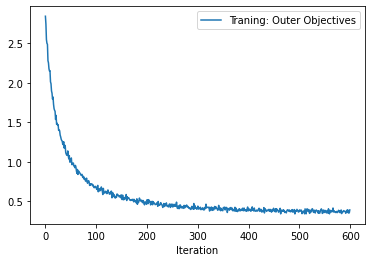

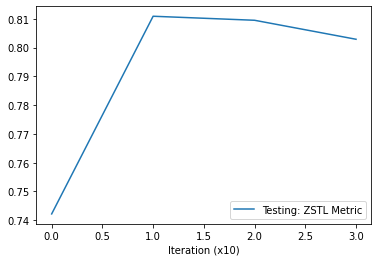

mAP at 100  tensor(0.3073, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13171232876712322
mean metric 0.3073453489406365
rho for w_kb 0.01; mu for a_kb 0.01;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7343999999999997; align loss 0.7640148401260376
1/600 o_loss 2.951011697053909; m train metric 0.7625; m test metric 0.7567999999999998; align loss  0.0007787942886352539
200/600 o_loss 0.4549552245438099; m train metric 0.8575999999999999; m test metric 0.8059000000000001; align loss  0.0006635785102844238
400/600 o_loss 0.40271164268255233; m train metric 0.8569; m test metric 0.8034000000000002; align loss  0.0005626082420349121
600/600 o_loss 0.3502468328922987; m train metric 0.8792; m test metric 0.8036000000000003; align loss  0.00047332048416137695
lr  0.0005


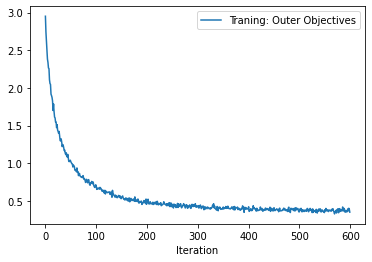

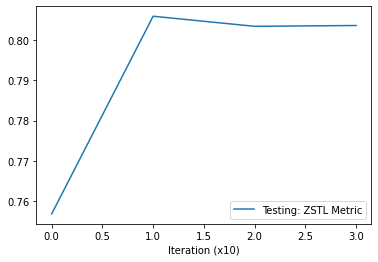

mAP at 100  tensor(0.3165, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13356164383561653
mean metric 0.31651641507757045
rho for w_kb 0.01; mu for a_kb 0.001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7104000000000003; align loss 0.7640147805213928
1/600 o_loss 2.8581437906622886; m train metric 0.7643999999999995; m test metric 0.7306999999999998; align loss  0.0007785558700561523
200/600 o_loss 0.4914247202128172; m train metric 0.8422999999999997; m test metric 0.8008000000000002; align loss  0.0006636381149291992
400/600 o_loss 0.3891014823317528; m train metric 0.8616000000000004; m test metric 0.8004000000000002; align loss  0.0005626082420349121
600/600 o_loss 0.37089011535048483; m train metric 0.8667999999999998; m test metric 0.8009; align loss  0.00047329068183898926
lr  0.0005


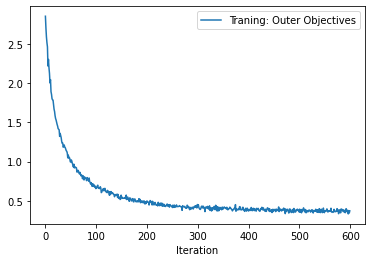

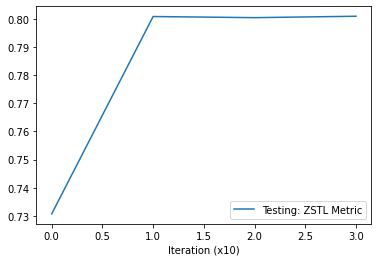

mAP at 100  tensor(0.3105, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1357191780821918
mean metric 0.31050381435914176
rho for w_kb 0.01; mu for a_kb 0.0001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7270000000000003; align loss 0.7640148401260376
1/600 o_loss 2.8369343131780624; m train metric 0.7603; m test metric 0.7467999999999998; align loss  0.0007787346839904785
200/600 o_loss 0.515708233639598; m train metric 0.8417999999999999; m test metric 0.8048999999999998; align loss  0.0006636381149291992
400/600 o_loss 0.3903000609576702; m train metric 0.8645000000000003; m test metric 0.7972999999999996; align loss  0.0005625486373901367
600/600 o_loss 0.3686316014826298; m train metric 0.8709999999999998; m test metric 0.7964000000000001; align loss  0.00047332048416137695
lr  0.0005


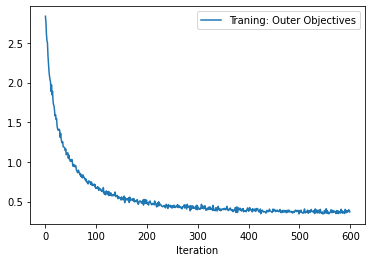

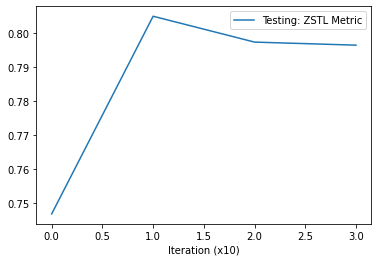

mAP at 100  tensor(0.3158, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13537671232876705
mean metric 0.31581426487808617
rho for w_kb 0.01; mu for a_kb 1e-05;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7109999999999999; align loss 0.7640147805213928
1/600 o_loss 2.929626696407795; m train metric 0.7323999999999998; m test metric 0.7276999999999998; align loss  0.0007781982421875
200/600 o_loss 0.4861528757214546; m train metric 0.8593000000000002; m test metric 0.7838000000000003; align loss  0.00066375732421875
400/600 o_loss 0.4058454093337059; m train metric 0.8481999999999994; m test metric 0.7815999999999996; align loss  0.0005626678466796875
600/600 o_loss 0.37322417136281727; m train metric 0.8621999999999994; m test metric 0.7797000000000002; align loss  0.00047335028648376465
lr  0.0005


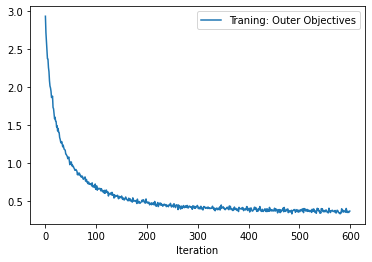

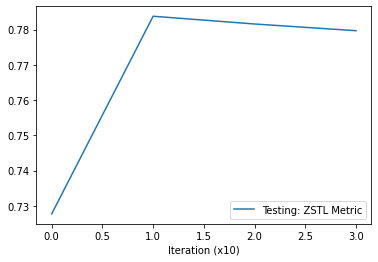

mAP at 100  tensor(0.3097, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13386986301369852
mean metric 0.30967584199664394
rho for w_kb 0.001; mu for a_kb 0.1;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7153; align loss 0.7640147805213928
1/600 o_loss 2.8243915861845017; m train metric 0.7617999999999999; m test metric 0.7372; align loss  0.0007790327072143555
200/600 o_loss 0.4702405882626772; m train metric 0.8549000000000002; m test metric 0.7986999999999999; align loss  0.0006635785102844238
400/600 o_loss 0.3828563956916332; m train metric 0.8636000000000001; m test metric 0.7945000000000003; align loss  0.0005626678466796875
600/600 o_loss 0.38325486723333596; m train metric 0.871; m test metric 0.7897000000000002; align loss  0.00047332048416137695
lr  0.0005


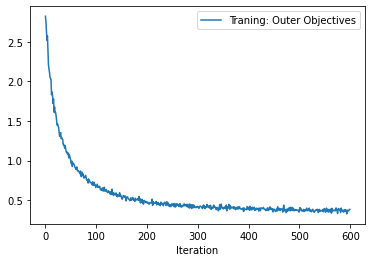

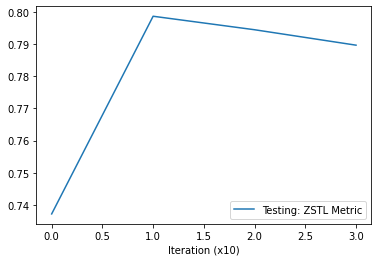

mAP at 100  tensor(0.3107, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13489726027397256
mean metric 0.31074810894311233
rho for w_kb 0.001; mu for a_kb 0.01;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.6998000000000001; align loss 0.7640147805213928
1/600 o_loss 2.9051372221112253; m train metric 0.7639; m test metric 0.7193999999999999; align loss  0.0007791519165039062
200/600 o_loss 0.4837960543483496; m train metric 0.8407000000000001; m test metric 0.7736999999999995; align loss  0.0006636977195739746
400/600 o_loss 0.393034817352891; m train metric 0.8576; m test metric 0.7770999999999998; align loss  0.0005625486373901367
600/600 o_loss 0.37195732943713666; m train metric 0.8731; m test metric 0.7729999999999997; align loss  0.00047340989112854004
lr  0.0005


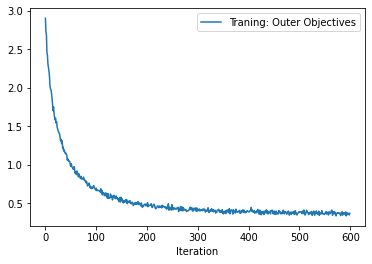

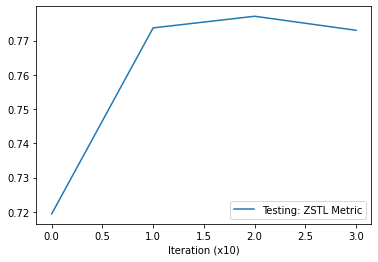

mAP at 100  tensor(0.3172, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13554794520547941
mean metric 0.3172019633221033
rho for w_kb 0.001; mu for a_kb 0.001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7266000000000002; align loss 0.7640148401260376
1/600 o_loss 2.94208153963089; m train metric 0.7585; m test metric 0.7471999999999999; align loss  0.0007789134979248047
200/600 o_loss 0.46712054789066315; m train metric 0.8611000000000004; m test metric 0.7988000000000003; align loss  0.0006635189056396484
400/600 o_loss 0.37625841215252875; m train metric 0.8688999999999996; m test metric 0.7957000000000004; align loss  0.0005626082420349121
600/600 o_loss 0.36243410244584084; m train metric 0.8712000000000002; m test metric 0.7884999999999998; align loss  0.00047338008880615234
lr  0.0005


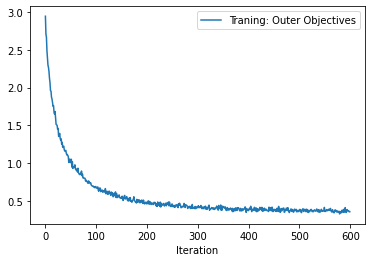

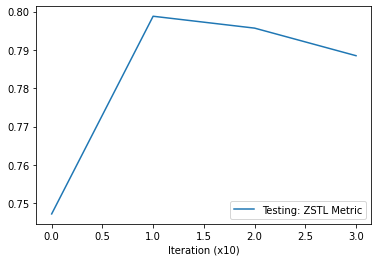

mAP at 100  tensor(0.3194, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13503424657534246
mean metric 0.31937605359678317
rho for w_kb 0.001; mu for a_kb 0.0001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7149000000000002; align loss 0.7640148997306824
1/600 o_loss 2.8651660108566284; m train metric 0.7490000000000001; m test metric 0.7315999999999999; align loss  0.0007790327072143555
200/600 o_loss 0.48935301579535007; m train metric 0.8584999999999998; m test metric 0.7925000000000001; align loss  0.0006635189056396484
400/600 o_loss 0.3782471448555589; m train metric 0.8685000000000003; m test metric 0.7929999999999998; align loss  0.0005625486373901367
600/600 o_loss 0.36225484769791366; m train metric 0.8752999999999999; m test metric 0.7907; align loss  0.00047346949577331543
lr  0.0005


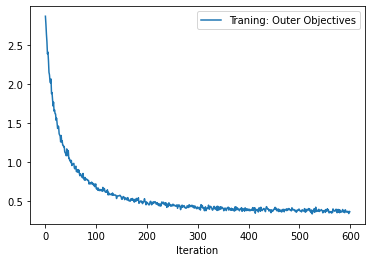

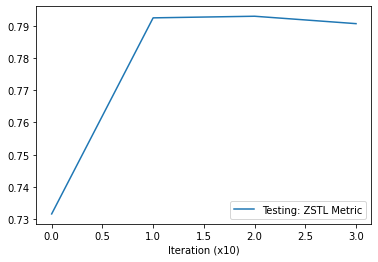

mAP at 100  tensor(0.3160, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1345890410958904
mean metric 0.31600157523303946
rho for w_kb 0.001; mu for a_kb 1e-05;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7200999999999997; align loss 0.7640146613121033
1/600 o_loss 2.8673088014125825; m train metric 0.7502999999999999; m test metric 0.7406000000000001; align loss  0.0007790923118591309
200/600 o_loss 0.4833829216659069; m train metric 0.8585000000000004; m test metric 0.7960000000000003; align loss  0.0006635785102844238
400/600 o_loss 0.3959175680577755; m train metric 0.8632999999999998; m test metric 0.7894000000000001; align loss  0.0005626082420349121
600/600 o_loss 0.40022159673273566; m train metric 0.8573000000000001; m test metric 0.7875000000000001; align loss  0.00047338008880615234
lr  0.0005


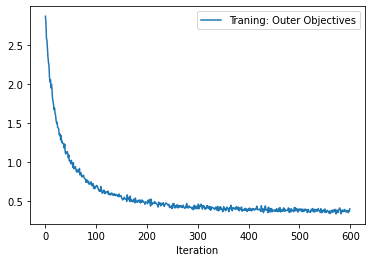

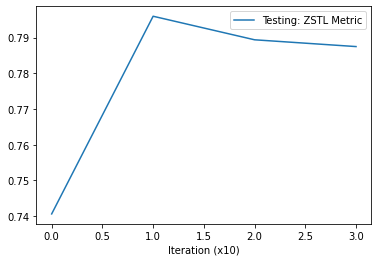

mAP at 100  tensor(0.3069, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1309931506849315
mean metric 0.30693127367507744
rho for w_kb 0.0001; mu for a_kb 0.1;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7187; align loss 0.7640147805213928
1/600 o_loss 2.937833377122879; m train metric 0.7492000000000004; m test metric 0.7390000000000002; align loss  0.0007788538932800293
200/600 o_loss 0.4692114792764187; m train metric 0.8532000000000001; m test metric 0.7931999999999997; align loss  0.0006636381149291992
400/600 o_loss 0.39414243899285795; m train metric 0.8596999999999998; m test metric 0.7932999999999996; align loss  0.0005626082420349121
600/600 o_loss 0.40081694260239603; m train metric 0.8501000000000001; m test metric 0.7910999999999998; align loss  0.00047332048416137695
lr  0.0005


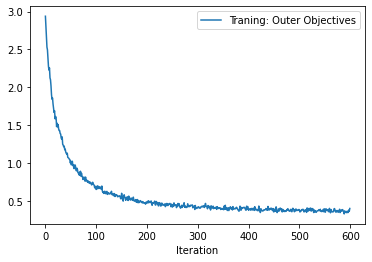

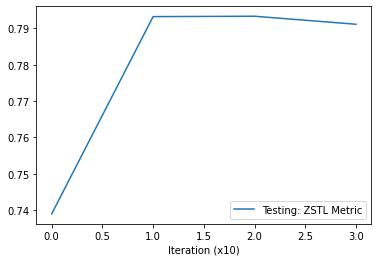

mAP at 100  tensor(0.3109, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1353082191780822
mean metric 0.3108938415468939
rho for w_kb 0.0001; mu for a_kb 0.01;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7130999999999997; align loss 0.7640147805213928
1/600 o_loss 2.9039195834100244; m train metric 0.7504000000000002; m test metric 0.7385; align loss  0.0007788538932800293
200/600 o_loss 0.4654944545775652; m train metric 0.8544999999999995; m test metric 0.7971000000000004; align loss  0.0006635785102844238
400/600 o_loss 0.41456395663321016; m train metric 0.8524999999999997; m test metric 0.7961000000000008; align loss  0.0005625486373901367
600/600 o_loss 0.398338188752532; m train metric 0.8492000000000001; m test metric 0.7959000000000002; align loss  0.00047335028648376465
lr  0.0005


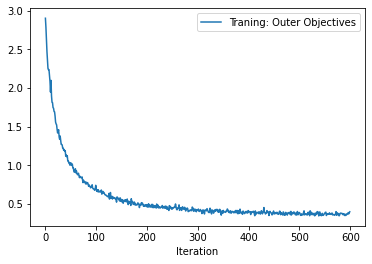

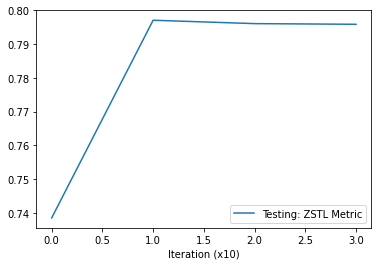

mAP at 100  tensor(0.3159, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13438356164383555
mean metric 0.315886191734884
rho for w_kb 0.0001; mu for a_kb 0.001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7115999999999998; align loss 0.7640148401260376
1/600 o_loss 2.95391315728426; m train metric 0.7441; m test metric 0.7284000000000005; align loss  0.0007788538932800293
200/600 o_loss 0.4804652366042137; m train metric 0.8636000000000001; m test metric 0.7863000000000003; align loss  0.0006636381149291992
400/600 o_loss 0.4000231168419123; m train metric 0.8560999999999999; m test metric 0.7835000000000004; align loss  0.0005624890327453613
600/600 o_loss 0.3697121138870716; m train metric 0.8794000000000003; m test metric 0.7828999999999998; align loss  0.00047335028648376465
lr  0.0005


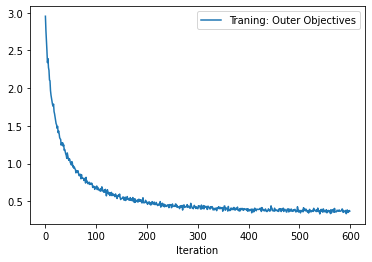

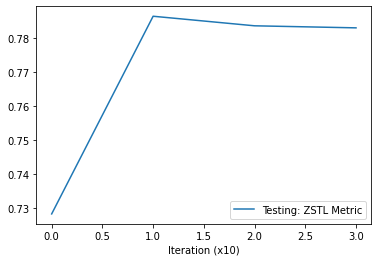

mAP at 100  tensor(0.3172, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13222602739726025
mean metric 0.3171605938326337
rho for w_kb 0.0001; mu for a_kb 0.0001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7189999999999998; align loss 0.7640148401260376
1/600 o_loss 2.863726463317871; m train metric 0.7490000000000003; m test metric 0.7382000000000001; align loss  0.0007788538932800293
200/600 o_loss 0.5222742465138435; m train metric 0.8381000000000002; m test metric 0.7941999999999997; align loss  0.0006635189056396484
400/600 o_loss 0.4030926512181759; m train metric 0.8582999999999998; m test metric 0.7884000000000003; align loss  0.0005626678466796875
600/600 o_loss 0.36180116325616835; m train metric 0.8783999999999997; m test metric 0.7837000000000002; align loss  0.00047343969345092773
lr  0.0005


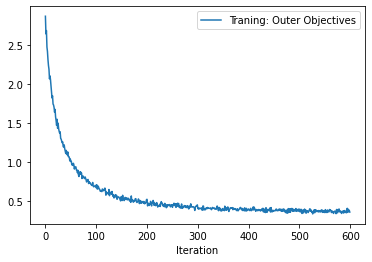

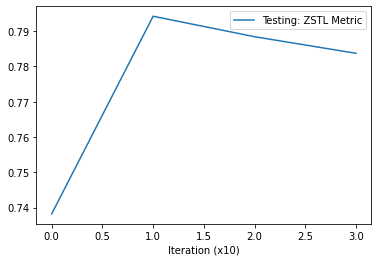

mAP at 100  tensor(0.3129, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1322945205479453
mean metric 0.3128542142613246
rho for w_kb 0.0001; mu for a_kb 1e-05;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7147000000000001; align loss 0.7640146613121033
1/600 o_loss 2.9488787540793417; m train metric 0.7421999999999999; m test metric 0.7317; align loss  0.0007786154747009277
200/600 o_loss 0.48435006007552145; m train metric 0.8417000000000001; m test metric 0.8019; align loss  0.0006636381149291992
400/600 o_loss 0.3880425250530243; m train metric 0.8683000000000001; m test metric 0.8063999999999997; align loss  0.0005626678466796875
600/600 o_loss 0.388868191242218; m train metric 0.8622000000000003; m test metric 0.8041999999999996; align loss  0.00047340989112854004
lr  0.0005


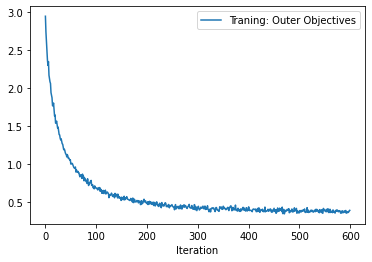

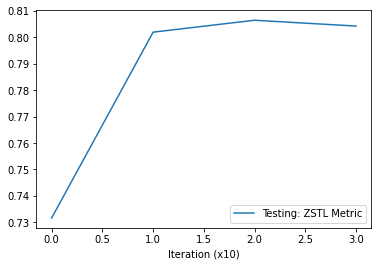

mAP at 100  tensor(0.3123, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13462328767123286
mean metric 0.3123176578624239
rho for w_kb 1e-05; mu for a_kb 0.1;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7005; align loss 0.7640147805213928
1/600 o_loss 2.93158343821764; m train metric 0.7481999999999996; m test metric 0.7198000000000002; align loss  0.0007783770561218262
200/600 o_loss 0.5080009504407644; m train metric 0.8329000000000002; m test metric 0.7846; align loss  0.0006635189056396484
400/600 o_loss 0.4144107790291309; m train metric 0.8638999999999997; m test metric 0.7767000000000001; align loss  0.0005626082420349121
600/600 o_loss 0.3697911382466555; m train metric 0.8624; m test metric 0.7758000000000002; align loss  0.00047335028648376465
lr  0.0005


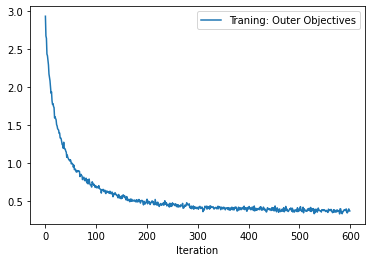

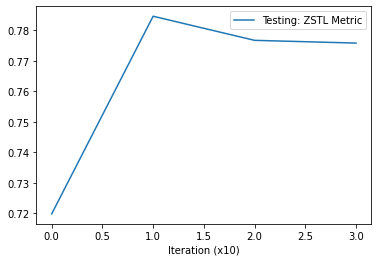

mAP at 100  tensor(0.3181, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13565068493150667
mean metric 0.3181318885547538
rho for w_kb 1e-05; mu for a_kb 0.01;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7193; align loss 0.764014720916748
1/600 o_loss 2.873110105395317; m train metric 0.7552; m test metric 0.7437999999999997; align loss  0.0007787942886352539
200/600 o_loss 0.46929343290627; m train metric 0.8499000000000001; m test metric 0.7994; align loss  0.0006636381149291992
400/600 o_loss 0.38979123011231426; m train metric 0.8596000000000003; m test metric 0.7991000000000001; align loss  0.0005627274513244629
600/600 o_loss 0.3735141675174236; m train metric 0.8672999999999996; m test metric 0.7943999999999999; align loss  0.00047335028648376465
lr  0.0005


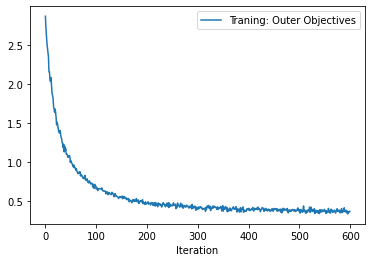

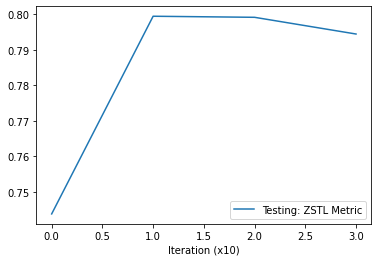

mAP at 100  tensor(0.3126, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13136986301369857
mean metric 0.31261856875210253
rho for w_kb 1e-05; mu for a_kb 0.001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7213000000000003; align loss 0.764014720916748
1/600 o_loss 2.966822205781937; m train metric 0.7383000000000004; m test metric 0.7395000000000002; align loss  0.0007788538932800293
200/600 o_loss 0.49696640960872174; m train metric 0.8506999999999999; m test metric 0.7937999999999998; align loss  0.0006635785102844238
400/600 o_loss 0.40517242297530176; m train metric 0.8686999999999998; m test metric 0.7926000000000002; align loss  0.0005626678466796875
600/600 o_loss 0.35107374891638754; m train metric 0.8830000000000001; m test metric 0.7879000000000004; align loss  0.00047332048416137695
lr  0.0005


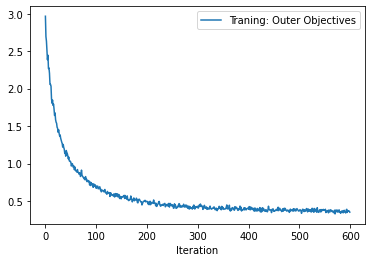

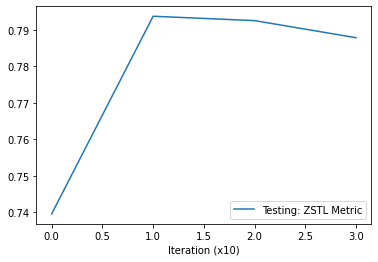

mAP at 100  tensor(0.3070, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.1323972602739727
mean metric 0.3070041419910267
rho for w_kb 1e-05; mu for a_kb 0.0001;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7250999999999999; align loss 0.7640149593353271
1/600 o_loss 2.895919799208641; m train metric 0.7532000000000001; m test metric 0.7426; align loss  0.0007788538932800293
200/600 o_loss 0.520464326813817; m train metric 0.84; m test metric 0.8083; align loss  0.0006635785102844238
400/600 o_loss 0.408947422914207; m train metric 0.8566000000000001; m test metric 0.8045; align loss  0.0005626082420349121
600/600 o_loss 0.3588558653742075; m train metric 0.8756999999999999; m test metric 0.8067999999999996; align loss  0.00047340989112854004
lr  0.0005


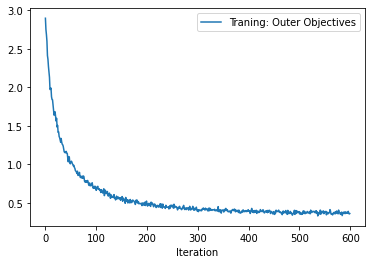

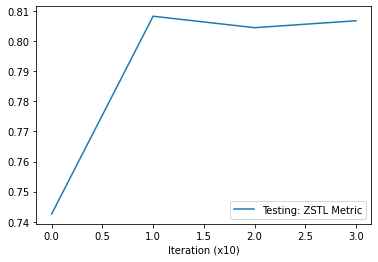

mAP at 100  tensor(0.3254, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13643835616438357
mean metric 0.32541873888508066
New best acc 0.32541873888508066
rho for w_kb 1e-05; mu for a_kb 1e-05;
test  torch.Size([1892, 100]) torch.Size([100]) torch.Size([100, 100, 9749]) torch.Size([100, 100, 1])
weight_kb  torch.Size([1950201, 50])
init mean test metric 0.7171999999999996; align loss 0.764014720916748
1/600 o_loss 2.86582553178072; m train metric 0.7568999999999998; m test metric 0.7361999999999999; align loss  0.0007793903350830078
200/600 o_loss 0.4810702496767044; m train metric 0.8504999999999998; m test metric 0.7938999999999994; align loss  0.0006635785102844238
400/600 o_loss 0.41292684458196166; m train metric 0.8472999999999999; m test metric 0.7902999999999998; align loss  0.0005626082420349121
600/600 o_loss 0.3875298500806093; m train metric 0.8640000000000003; m test metric 0.7866000000000001; align loss  0.00047329068183898926
lr  0.00

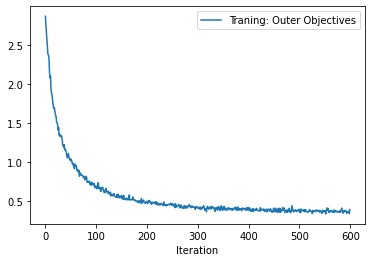

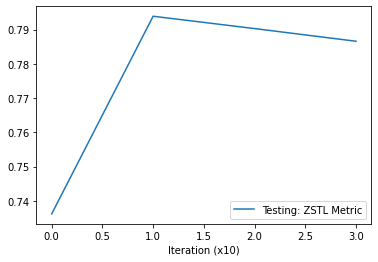

mAP at 100  tensor(0.3138, dtype=torch.float64) num task  tensor(292., dtype=torch.float64) precision at k 0.13650684931506846
mean metric 0.313761933953827
best_hp  {'mu': 0.0001, 'rho': 1e-05}


In [ ]:
indx = train_indx
np.random.seed(0)
val_indx = list(np.random.choice(indx, size=int(len(indx)*0.2), replace=False))
print(len(val_indx))
train_indx_splited = [x for x in indx if x not in val_indx]
print(len(train_indx_splited))

val_data_full = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in val_indx], detailed_dataset, phase='mAP', preset_x =preset_x, train_task=False, \
                            learner='NN', device=device)
val_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in val_indx], detailed_dataset, phase='Normal', preset_x =preset_x, train_task=False, \
                            learner='NN', device=device)
train_splited_data = utils.Dataset_hetrec([(d, compressed_dataset[d]) for d in train_indx_splited], detailed_dataset, phase='Normal', preset_x =preset_x, \
                                    train_task=False, learner='NN', device=device)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
val_loader_full = DataLoader(val_data_full, batch_size=int(len(val_indx)), shuffle=True)
train_splited_loader = DataLoader(train_splited_data, batch_size=100, shuffle=True)

best_hp = utils.hp_select_mAP(train_splited_loader, val_loader, support_loader, val_loader_full, utils.toTensor(preset_x), d, dm, net, shape_record, device, \
                              val_step = 600, activation='Sparsemax')
print('best_hp ', best_hp)

In [ ]:
print(best_hp)

{'mu': 0.0001, 'rho': 1e-05}
